In [23]:
import matplotlib.pyplot as plt
import pandas as pd
from libraries import tfim_functions
from libraries import utils
from libraries import training
import torch
import torch.nn as nn
import numpy as np
import kan

In [2]:
slow = pd.read_csv('data/KAN_n_10_data.csv')
slow

,N,h,trial,epoch,energy,epoch time
0,10.0,0.1,0.0,0.0,-0.781127,8.286679
1,10.0,0.1,0.0,1.0,-1.494213,10.640559
2,10.0,0.1,0.0,2.0,-0.891111,8.384462
3,10.0,0.1,0.0,3.0,-0.854585,10.572844
4,10.0,0.1,0.0,4.0,-1.256293,19.571631
...,...,...,...,...,...,...
2995,10.0,10.0,4.0,195.0,-100.234726,18.347239
2996,10.0,10.0,4.0,196.0,-100.277390,19.370258
2997,10.0,10.0,4.0,197.0,-100.225487,18.756880
2998,10.0,10.0,4.0,198.0,-100.237228,18.106349


In [3]:
fast = pd.read_csv('data/KAN_n_10_20_data.csv')
fast

,N,h,trial,epoch,energy,epoch time
0,10.0,0.1,0.0,0.0,-0.864003,2.530869
1,10.0,0.1,0.0,1.0,-0.997443,2.491019
2,10.0,0.1,0.0,2.0,-0.865927,2.856023
3,10.0,0.1,0.0,3.0,-0.996215,2.834610
4,10.0,0.1,0.0,4.0,-1.144669,2.426058
...,...,...,...,...,...,...
1795,20.0,10.0,0.0,295.0,-200.500534,18.459780
1796,20.0,10.0,0.0,296.0,-200.507935,18.931939
1797,20.0,10.0,0.0,297.0,-200.500778,18.060876
1798,20.0,10.0,0.0,298.0,-200.497589,18.792846


In [4]:
fast['energy'].loc[(fast['N'] == 10) & (fast['h'] == 0.1) & (fast['trial'] == 0)]

0     -0.864003
1     -0.997443
2     -0.865927
3     -0.996215
4     -1.144669
         ...   
295   -6.328246
296   -6.316940
297   -6.337694
298   -6.311986
299   -6.332645
Name: energy, Length: 300, dtype: float64

In [5]:
slow['energy'].loc[(slow['N'] == 10) & (slow['h'] == 0.1) & (slow['trial'] == 0)]

0      -0.781127
1      -1.494213
2      -0.891111
3      -0.854585
4      -1.256293
         ...    
195   -10.019991
196   -10.019774
197    -9.911407
198   -10.018473
199   -10.017533
Name: energy, Length: 200, dtype: float64

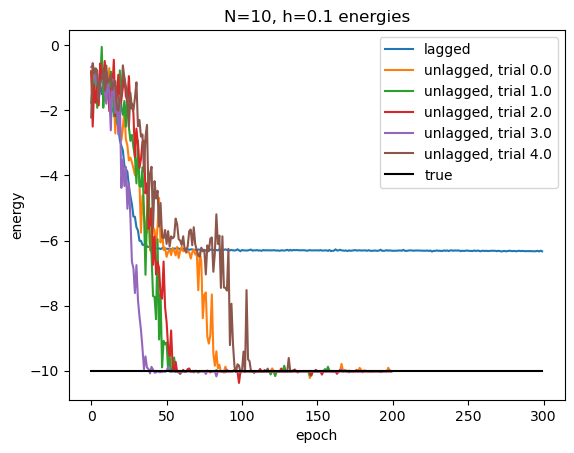

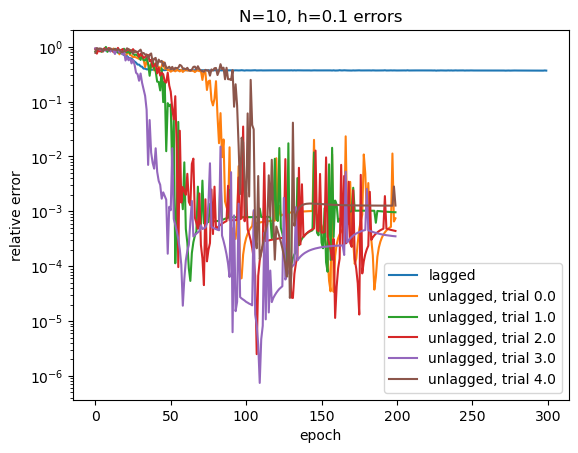

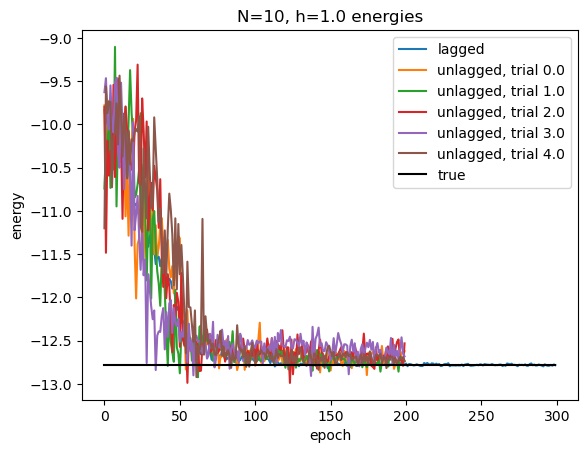

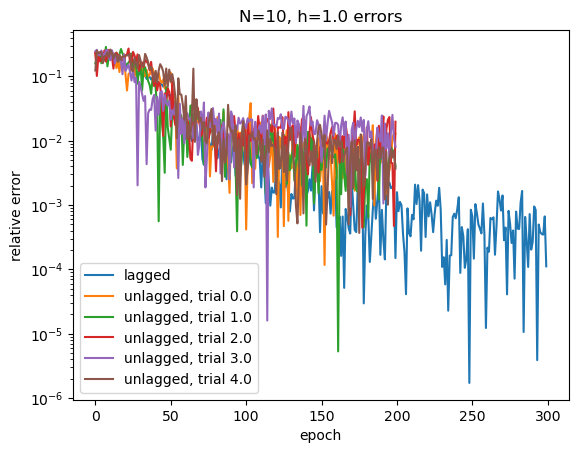

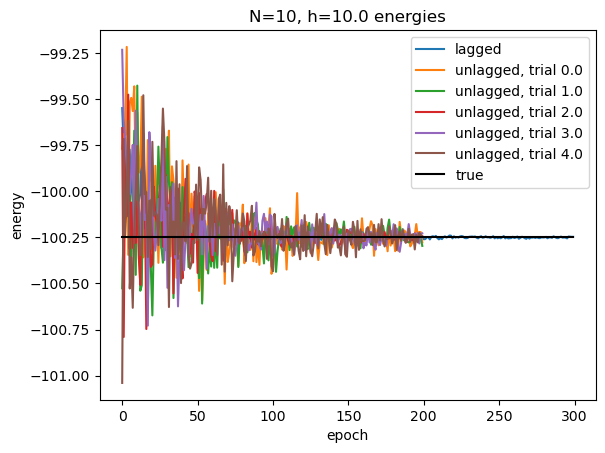

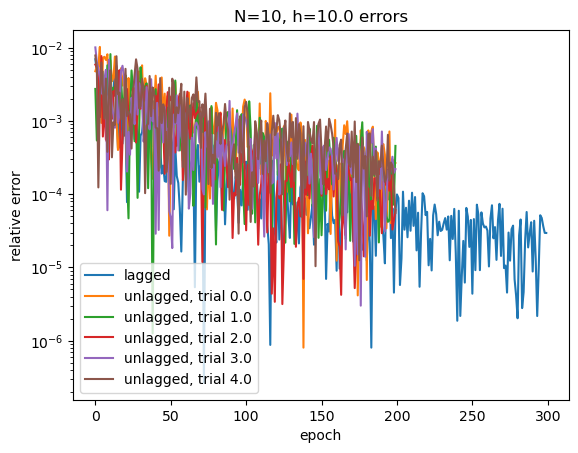

In [6]:
N = 10
fast_epochs = fast['epoch'].unique()
slow_epochs = slow['epoch'].unique()
for h in fast['h'].unique():
    true_gse = tfim_functions.ground_state_energy(h, N)
    lagged_energies = fast['energy'].loc[(fast['N'] == N) & (fast['h'] == h) & (fast['trial'] == 0)]
    plt.plot(fast_epochs, lagged_energies, label = 'lagged')
    for t in slow['trial'].unique():
        unlagged_energies = slow['energy'].loc[(slow['N'] == N) & (slow['h'] == h) & (slow['trial'] == t)]
        plt.plot(slow_epochs, unlagged_energies, label = f'unlagged, trial {t}')
    plt.plot([0, fast_epochs[-1]], [true_gse] * 2, color = 'black', label = 'true')
    plt.xlabel('epoch')
    plt.ylabel('energy')
    plt.title(f'N={N}, h={h} energies')
    plt.legend(loc = 'best')
    plt.show()

    lagged_errors = abs((lagged_energies - true_gse) / true_gse)
    plt.plot(fast_epochs, lagged_errors, label = 'lagged')
    for t in slow['trial'].unique():
        unlagged_energies = slow['energy'].loc[(slow['N'] == N) & (slow['h'] == h) & (slow['trial'] == t)]
        unlagged_errors = abs((unlagged_energies - true_gse) / true_gse)
        plt.plot(slow_epochs, unlagged_errors, label = f'unlagged, trial {t}')
    plt.xlabel('epoch')
    plt.ylabel('relative error')
    plt.yscale('log')
    plt.title(f'N={N}, h={h} errors')
    plt.legend(loc = 'best')
    plt.show()

In [24]:
model_n_10_01 = kan.KAN(width=[10, 10, 2])
model_n_10_01.load_state_dict(torch.load('models/n_10_h_0.1_GSE_-6.333.pt', weights_only=True))
model_n_10_01.eval()

checkpoint directory created: ./model
saving model version 0.0


MultKAN(
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)

In [26]:
utils.log_amp_phase(model_n_10_01(utils.generate_input_torch(10)))

tensor([1.6984e-01-1.4796e-02j, 2.2071e-01-8.0936e-03j, 7.4687e-02-3.1441e-03j,
         ..., 1.8004e-04-1.1546e-05j, 9.2239e-05+1.1640e-05j,
        1.4818e-04+3.1332e-06j], grad_fn=<ExpBackward0>)

In [11]:
true_gs = tfim_functions.TFIM_hamiltonian(10, 1, 0.1).eigenstates()[1][0]
true_gs

Quantum object: dims=[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], shape=(1024, 1), type='ket', dtype=Dense
Qobj data =
[[0.70463164]
 [0.01762683]
 [0.01762683]
 ...
 [0.01763997]
 [0.01763997]
 [0.70515686]]

In [15]:
true_gs.full().reshape((1024,))

array([0.70463164+0.j, 0.01762683+0.j, 0.01762683+0.j, ...,
       0.01763997+0.j, 0.01763997+0.j, 0.70515686+0.j])

In [27]:
true_gs = tfim_functions.TFIM_hamiltonian(10, 1, 0.1).eigenstates()[1][0]
model_gs = training.model_to_ground_state(10, model_n_10_01, utils.log_amp_phase)#model_n_10_01(utils.generate_input_torch(10))
true_prob_amps = np.abs(np.squeeze(true_gs.full()) ** 2)
model_prob_amps = np.abs(np.squeeze(model_gs.full()) ** 2)

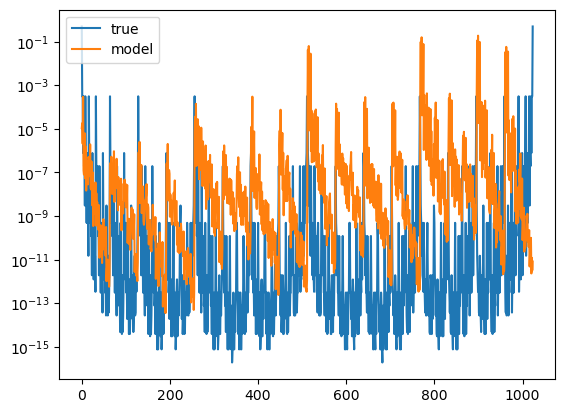

In [29]:
xs = [n for n in range(0, 1024)]
plt.plot(xs, true_prob_amps, label = 'true')
plt.plot(xs, model_prob_amps, label = 'model')
plt.legend(loc = 'best')
plt.yscale('log')
plt.show()

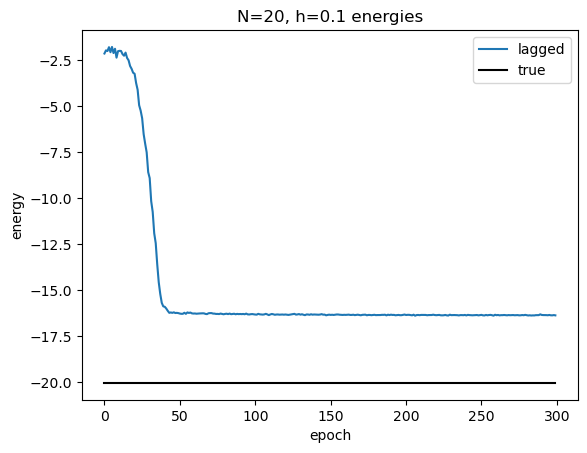

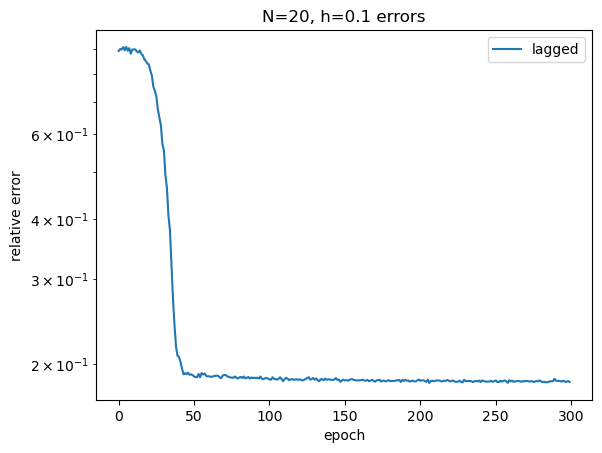

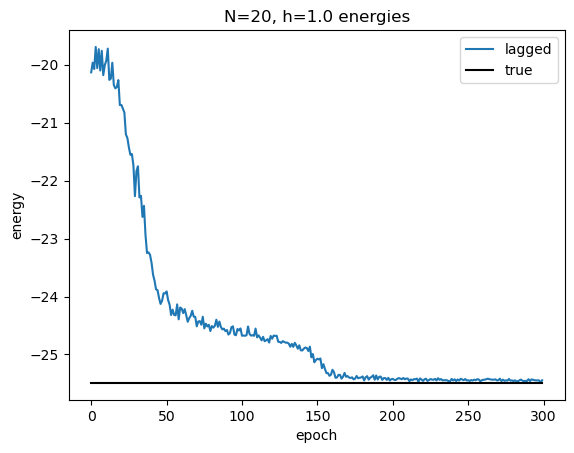

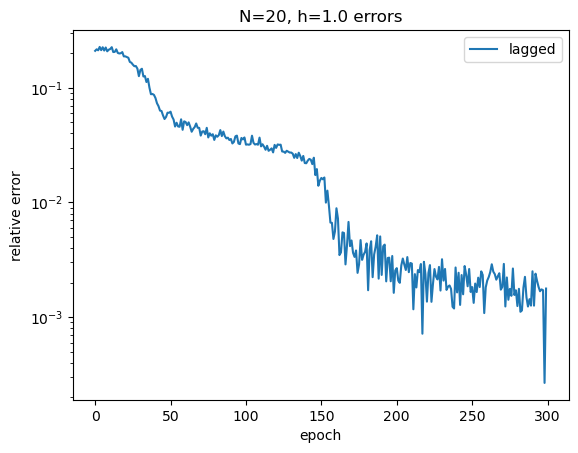

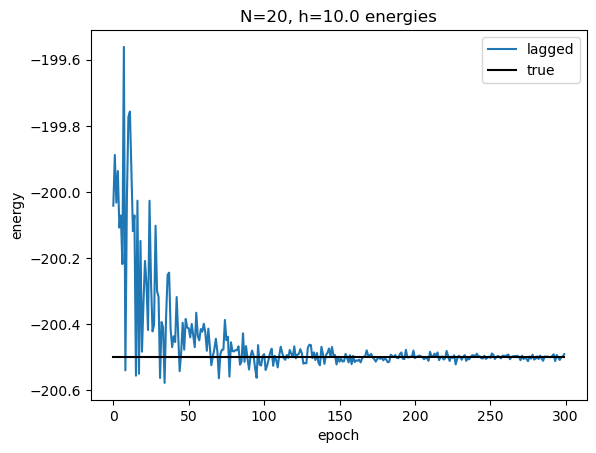

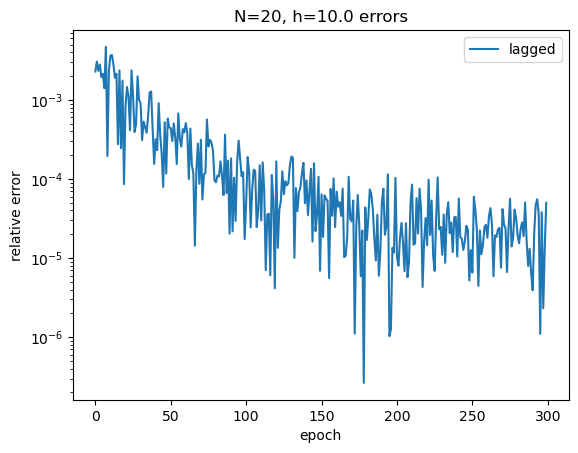

In [7]:
N = 20
fast_epochs = fast['epoch'].unique()
for h in fast['h'].unique():
    true_gse = tfim_functions.ground_state_energy(h, N)
    lagged_energies = fast['energy'].loc[(fast['N'] == N) & (fast['h'] == h) & (fast['trial'] == 0)]
    plt.plot(fast_epochs, lagged_energies, label = 'lagged')
    plt.plot([0, fast_epochs[-1]], [true_gse] * 2, color = 'black', label = 'true')
    plt.xlabel('epoch')
    plt.ylabel('energy')
    plt.title(f'N={N}, h={h} energies')
    plt.legend(loc = 'best')
    plt.show()

    lagged_errors = abs((lagged_energies - true_gse) / true_gse)
    plt.plot(fast_epochs, lagged_errors, label = 'lagged')
    plt.xlabel('epoch')
    plt.ylabel('relative error')
    plt.yscale('log')
    plt.title(f'N={N}, h={h} errors')
    plt.legend(loc = 'best')
    plt.show()

In [33]:
evals = tfim_functions.TFIM_hamiltonian(10, 1, 0.1).eigenstates()[0]
print(evals)
for e in evals:
    print(e)

[-10.02501566 -10.02501566  -6.40332833 ...   6.40332833  10.02501566
  10.02501566]
-10.025015664234315
-10.025015664197381
-6.403328329875423
-6.383063872075751
-6.383063872075744
-6.341112079954132
-6.324788023859905
-6.324788023859899
-6.32478802385989
-6.324788023859885
-6.277507922364226
-6.277507922364222
-6.246247717844351
-6.235556130242622
-6.235556130242615
-6.235556130242613
-6.235556130242602
-6.204196872830701
-6.2041968728306935
-6.204196872830684
-6.20419687283068
-6.154456900119453
-6.154456900119435
-6.130000180531071
-6.125656566815171
-6.1256565668151595
-6.125656566815155
-6.125656566815154
-6.1125051079978165
-6.112505107997816
-6.112505107997813
-6.11250510799781
-6.090442211551551
-6.090442211551549
-6.090442211551546
-6.090442211551524
-6.060018298032701
-6.060018298032699
-6.025015664197376
-6.02308888292249
-6.023088882922475
-6.0230888829224645
-6.023088882922456
-6.018066505911092
-6.018066505911087
-6.018066505911081
-6.018066505911068
-6.011901905536018
-